In [ ]:
import pandas as pd
import mysql.connector
import os

# CSV file and target table name
csv_file = 'Crime_Data_from_2020_to_Present.csv'
table_name = 'crime_data'

# 📁 Path to the full file (you uploaded this file)
file_path = r"C:\Users\BIT\Downloads\Crime_Data_from_2020_to_Present.csv"

# 🔌 Connect to MySQL
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='##########',
    database='crime_rate'  # Make sure this DB exists
)
cursor = conn.cursor()

# 🧠 Data type mapping function
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# 🚀 Load the crime dataset
print(f"\n🔄 Processing: {csv_file} → {table_name}")

# Read CSV to DataFrame
df = pd.read_csv(r"C:\Users\BIT\Downloads\Crime_Data_from_2020_to_Present.csv")

# Replace NaNs with None
df = df.where(pd.notnull(df), None)

# Clean column names for SQL compatibility
df.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

# 🔧 Generate and execute CREATE TABLE
columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
cursor.execute(create_table_query)

# ⬇️ Insert data into table
for _, row in df.iterrows():
    values = tuple(None if pd.isna(x) else x for x in row)
    placeholders = ', '.join(['%s'] * len(row))
    insert_query = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({placeholders})"
    cursor.execute(insert_query, values)

# 💾 Commit
conn.commit()
print(f"✅ Loaded {len(df)} rows into `{table_name}`")

# 🔚 Close connection
conn.close()
print("\n🎉 Crime dataset successfully loaded into MySQL.")



🔄 Processing: Crime_Data_from_2020_to_Present.csv → crime_data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Shruti@1104",
                             database = "crime_rate")

cur = db.cursor()

    Year  Month  Total Crimes       Date
0   2020      1         18576 2020-01-01
1   2020      2         17284 2020-02-01
2   2020      3         16188 2020-03-01
3   2020      4         15706 2020-04-01
4   2020      5         17230 2020-05-01
..   ...    ...           ...        ...
60  2025      1            26 2025-01-01
61  2025      2            44 2025-02-01
62  2025      3            24 2025-03-01
63  2025      4             1 2025-04-01
64  2025      5             2 2025-05-01

[65 rows x 4 columns]


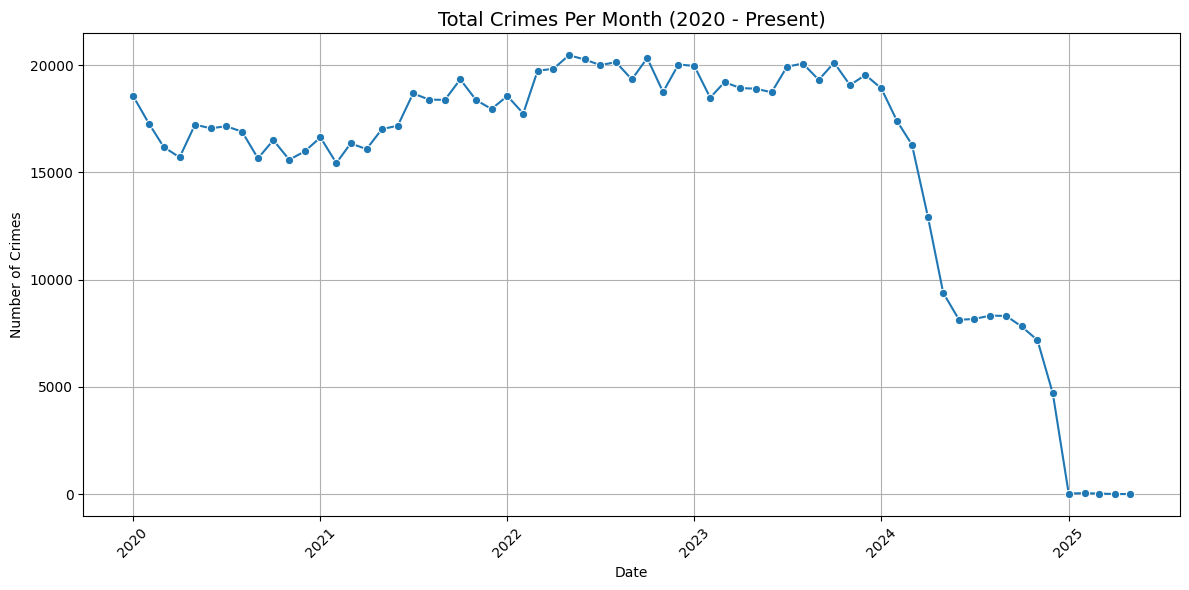

In [2]:
#1.Total crimes per year and month
query = """
SELECT 
    YEAR(STR_TO_DATE(DATE_OCC, '%m/%d/%Y')) AS crime_year,
    MONTH(STR_TO_DATE(DATE_OCC, '%m/%d/%Y')) AS crime_month,
    COUNT(*) AS total_crimes
FROM 
    crime_data
WHERE 
    STR_TO_DATE(DATE_OCC, '%m/%d/%Y') IS NOT NULL
GROUP BY 
    crime_year, crime_month
ORDER BY 
    crime_year, crime_month;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Year', 'Month', 'Total Crimes'])

# Step 4: Create Date column
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2))

# Step 5: Display and Plot
print(df)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Total Crimes', marker='o')
plt.title('Total Crimes Per Month (2020 - Present)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


                                               Crime  Number_of_times
0                                   VEHICLE - STOLEN           115190
1                           BATTERY - SIMPLE ASSAULT            74839
2                              BURGLARY FROM VEHICLE            63517
3                                  THEFT OF IDENTITY            62537
4  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...            61092


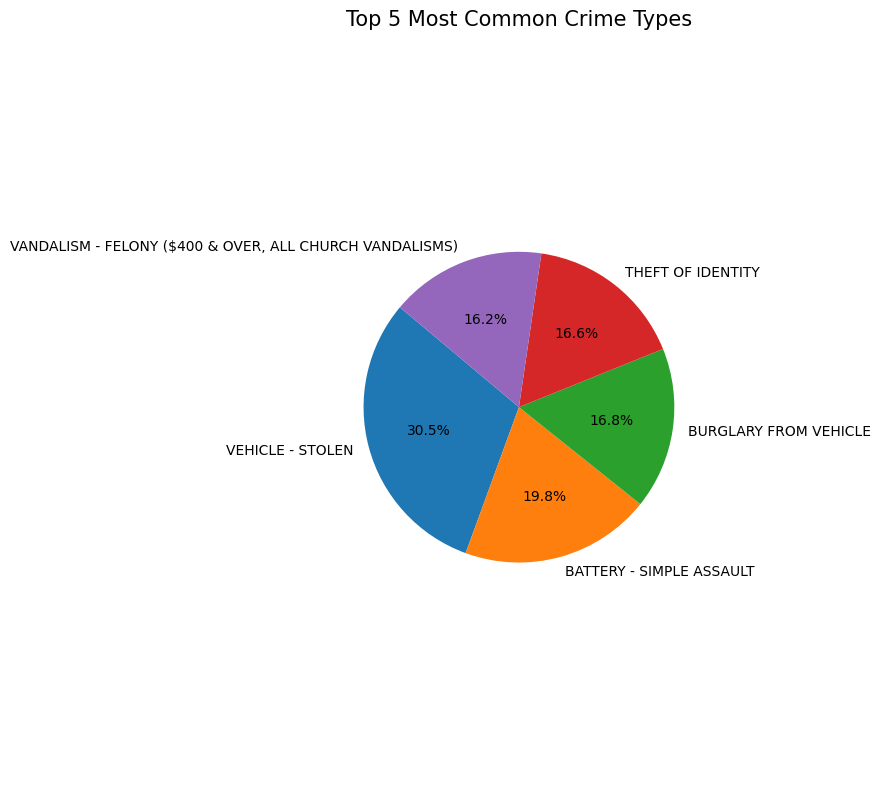

In [3]:
#2.Top 5 most common crime types
query="""Select Crm_Cd_Desc, count(*) from crime_data group by Crm_Cd_Desc order by count(*) desc limit 5"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=['Crime','Number_of_times'])
print(df)
labels = df['Crime']
sizes = df['Number_of_times']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Top 5 Most Common Crime Types", fontsize=15)
plt.axis('equal')  # Makes the pie a circle
plt.tight_layout()
plt.show()

  Gender   Count
0      M  403879
1      F  358580
2   None  144644
3      X   97773
4      H     114
5      -       1


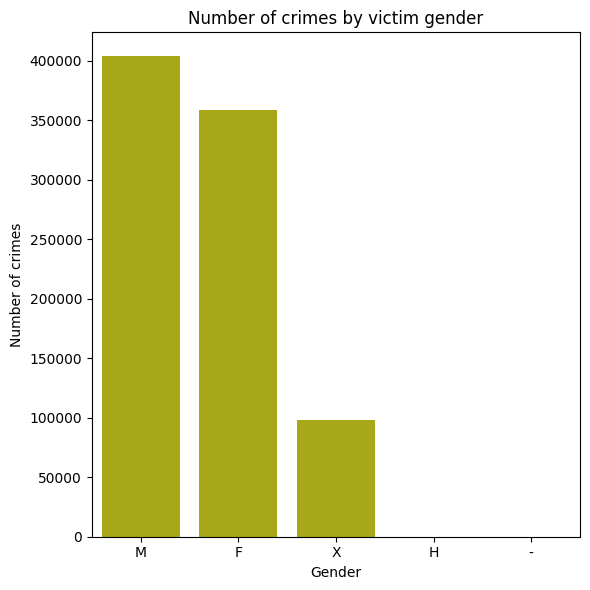

In [4]:
#3.Number of crimes by victim gender 
query ="""Select Vict_Sex, count(*) from crime_data group by Vict_Sex"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Gender','Count'])
print(df)
plt.figure(figsize=(6,6))
sns.barplot(data=df,x='Gender',y='Count',color='y')
plt.title("Number of crimes by victim gender")
plt.xlabel('Gender')
plt.ylabel('Number of crimes')
plt.tight_layout()
plt.show()

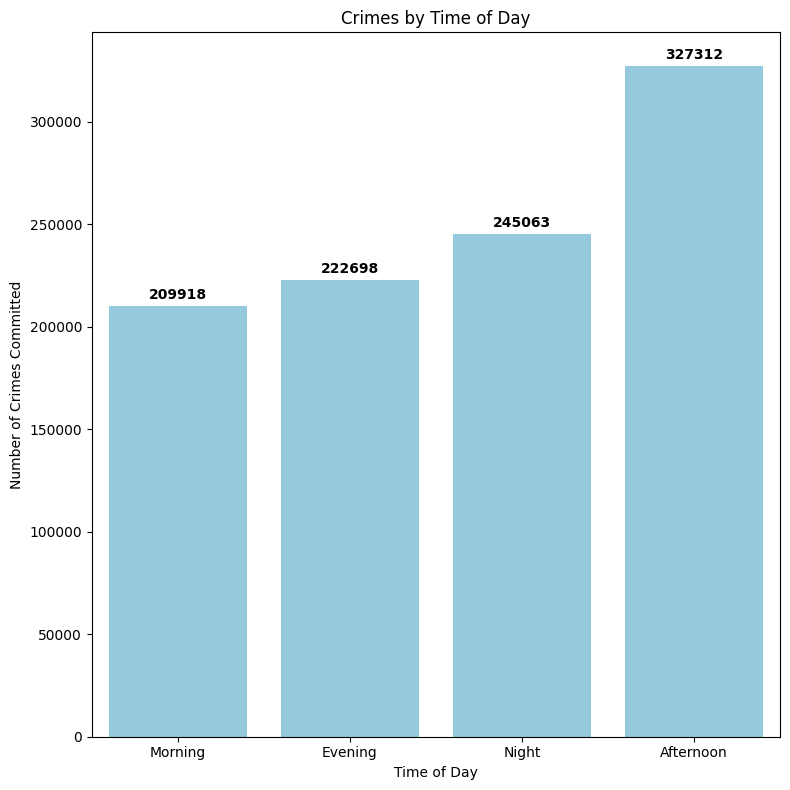

In [5]:
#4.Crimes by time of day
query ="""SELECT 
  CASE 
    WHEN TIME_OCC BETWEEN 600 AND 1159 THEN 'Morning'
    WHEN TIME_OCC BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN TIME_OCC BETWEEN 1800 AND 2159 THEN 'Evening'
    ELSE 'Night'
  END AS time_of_day,
  COUNT(*) AS total_crimes
FROM crime_data
GROUP BY 
  CASE 
    WHEN TIME_OCC BETWEEN 600 AND 1159 THEN 'Morning'
    WHEN TIME_OCC BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN TIME_OCC BETWEEN 1800 AND 2159 THEN 'Evening'
    ELSE 'Night'
  END
ORDER BY total_crimes"""
cur.execute(query)
data = cur.fetchall()

# Use consistent column names
df = pd.DataFrame(data, columns=['Time of Day', 'Number of Crimes'])

# Plot
plt.figure(figsize=(8,8))
ax = sns.barplot(data=df, x='Time of Day', y='Number of Crimes', color='skyblue')

# Add value labels
ax.bar_label(ax.containers[0], padding=3, fontsize=10, fontweight='bold')

# Labels and styling
plt.xlabel("Time of Day")
plt.ylabel("Number of Crimes Committed")
plt.title("Crimes by Time of Day")
plt.tight_layout()
plt.show()


     Weapon Code  Year  Total Crimes
0          400.0  2020         39530
1          500.0  2020          7899
2          511.0  2020          5221
3          102.0  2020          3957
4          109.0  2020          1567
..           ...   ...           ...
374        400.0  2025            22
375        511.0  2025             4
376        500.0  2025             3
377        212.0  2025             1
378        200.0  2025             1

[379 rows x 3 columns]


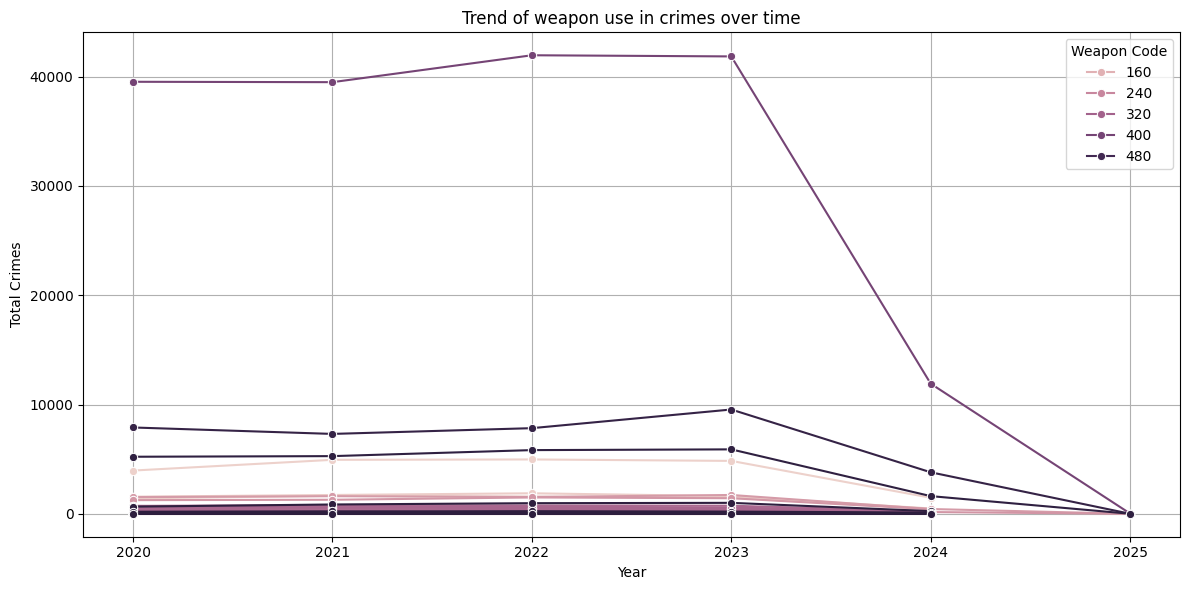

In [6]:
#5.Trend of weapon use in crimes over time
query = """
SELECT 
    Weapon_Used_Cd, 
    YEAR(STR_TO_DATE(DATE_OCC, '%m/%d/%Y')) AS crime_year,
    COUNT(*) AS total_crimes
FROM 
    crime_data
WHERE 
    Weapon_Used_Cd IS NOT NULL AND
    STR_TO_DATE(DATE_OCC, '%m/%d/%Y') IS NOT NULL
GROUP BY 
    crime_year, Weapon_Used_Cd
ORDER BY 
    crime_year, total_crimes DESC
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Weapon Code', 'Year', 'Total Crimes'])
print(df)
plt.figure(figsize=(12,6))
sns.lineplot(data=df,x='Year',y='Total Crimes',hue='Weapon Code', marker='o')
plt.title("Trend of weapon use in crimes over time")
plt.xlabel('Year')
plt.ylabel("Total Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
#6.Which area has the highest average daily crime rate?
query =""" SELECT 
    AREA_NAME, 
    AVG(daily_crime_count) AS avg_daily_crimes
FROM (
    SELECT 
        AREA_NAME, 
        STR_TO_DATE(DATE_OCC, '%m/%d/%Y') AS crime_date,
        COUNT(*) AS daily_crime_count
    FROM crime_data
    WHERE DATE_OCC IS NOT NULL
    GROUP BY AREA_NAME, STR_TO_DATE(DATE_OCC, '%m/%d/%Y')
) AS daily_crime_stats
GROUP BY AREA_NAME
ORDER BY avg_daily_crimes DESC
LIMIT 1;
"""
cur.execute(query)
data=cur.fetchall()
data

[('Central', Decimal('38.1336'))]

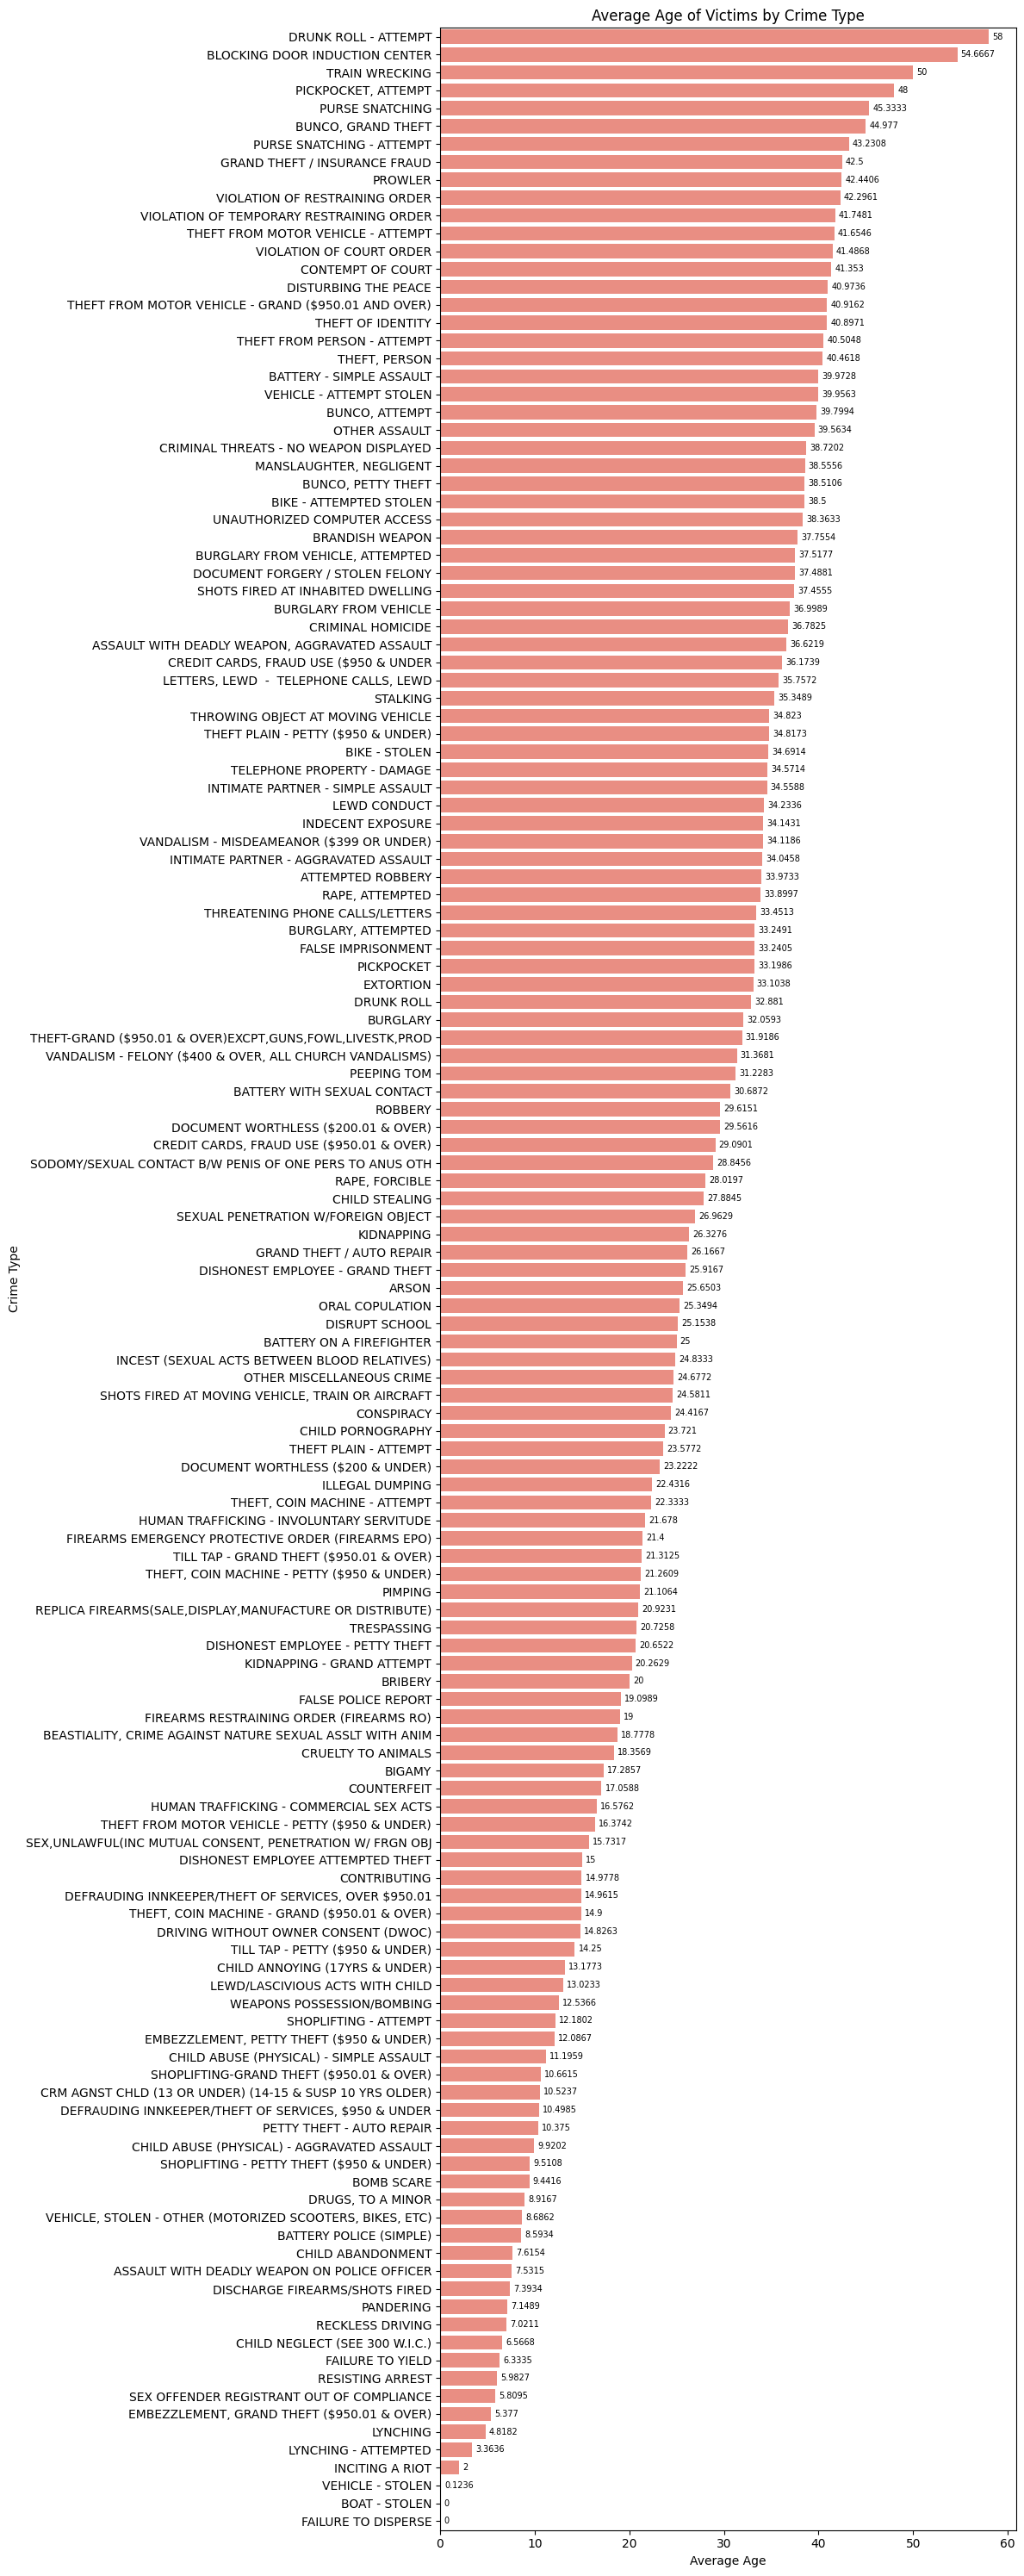

In [8]:
#7.Average victim age by crime type
query="""SELECT Crm_Cd_Desc, AVG(Vict_Age) AS Avg_Age
FROM crime_data
WHERE Vict_Age IS NOT NULL
GROUP BY Crm_Cd_Desc
ORDER BY Avg_Age DESC;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Crime','Avg_age'])
df
plt.figure(figsize=(12, 30))  # Increase height to fit labels
ax = sns.barplot(data=df.sort_values('Avg_age', ascending=False), 
                 y='Crime', x='Avg_age', color='salmon')
ax.bar_label(ax.containers[0], padding=3, fontsize=7)
plt.title("Average Age of Victims by Crime Type")
plt.xlabel("Average Age")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()


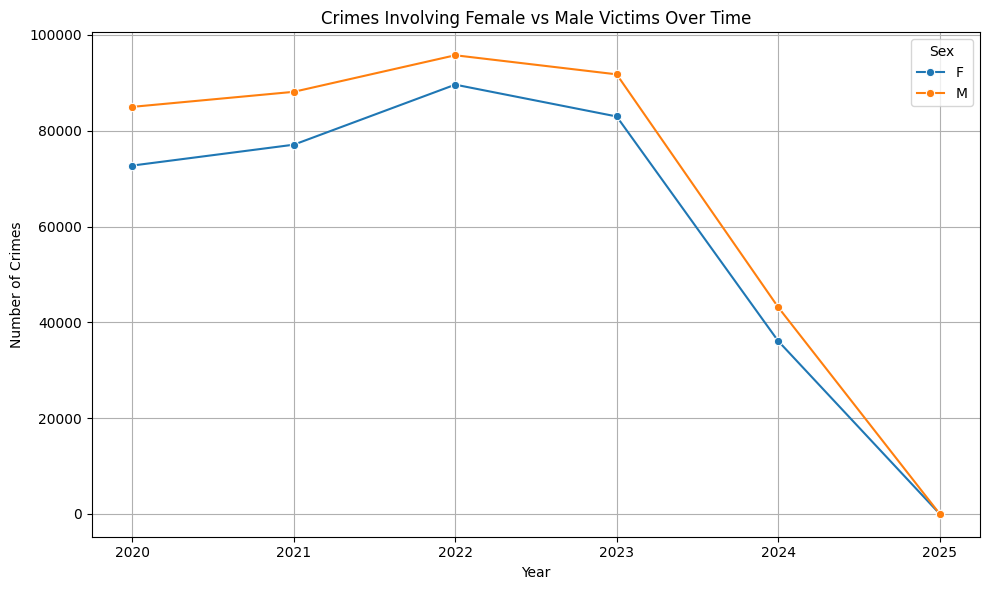

In [9]:
#8.Crimes involving female victims vs male victims over time
query = """
SELECT Vict_Sex,YEAR(STR_TO_DATE(DATE_OCC, '%m/%d/%Y')) AS crime_year, COUNT(*) AS total_crimes
FROM crime_data
WHERE Vict_Sex IN ('M', 'F') AND DATE_OCC IS NOT NULL
GROUP BY Vict_Sex, crime_year
ORDER BY crime_year, Vict_Sex;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['Sex', 'Year', 'Total Crimes'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Total Crimes', hue='Sex', marker='o')
plt.title("Crimes Involving Female vs Male Victims Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()


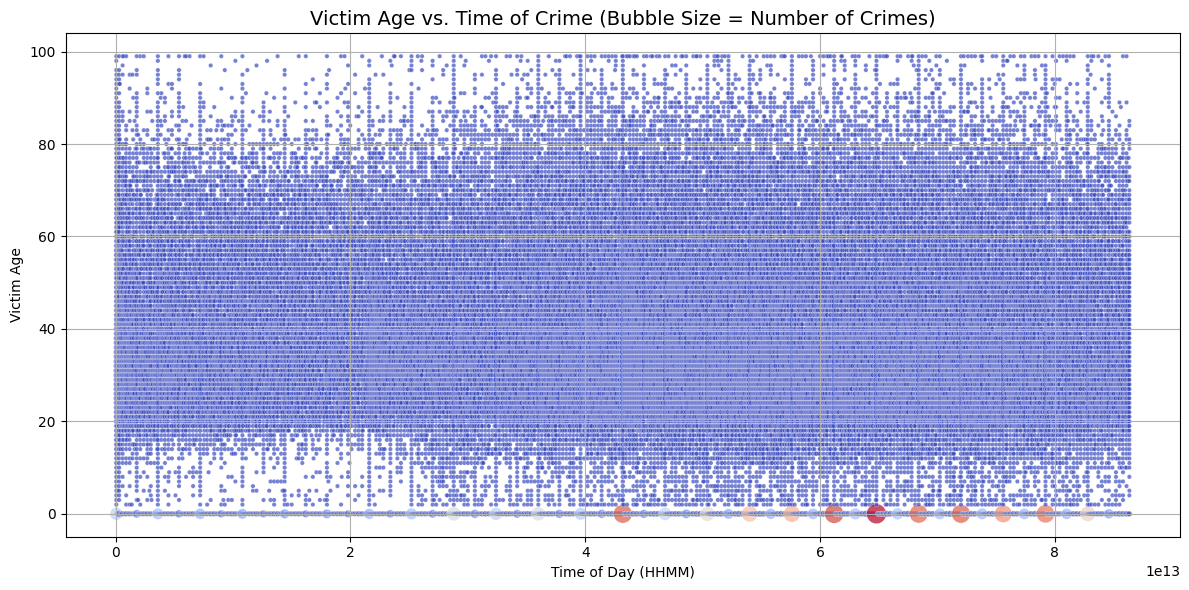

In [10]:
#9.Is there any correlation between time of crime and victim age?

query="""SELECT  Vict_Age, STR_TO_DATE(LPAD(TIME_OCC, 4, '0'), '%H%i') AS crime_time,
    COUNT(*) AS total_crimes
FROM crime_data
WHERE TIME_OCC IS NOT NULL AND Vict_Age IS NOT NULL
GROUP BY Vict_Age, crime_time
ORDER BY crime_time, Vict_Age;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Age','Time','Count'])
df = df[(df['Age'] >= 0) & (df['Age'] <= 100)]
df = df[df['Time'].notnull()]  # Remove rows where time conversion failed

# Plotting the scatter plot
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=df,
    x='Time',
    y='Age',
    size='Count',          # size of dots reflects the number of crimes
    sizes=(10, 200),
    hue='Count',
    palette='coolwarm',
    alpha=0.7,
    legend=False
)

plt.title('Victim Age vs. Time of Crime (Bubble Size = Number of Crimes)', fontsize=14)
plt.xlabel('Time of Day (HHMM)')
plt.ylabel('Victim Age')
plt.grid(True)
plt.tight_layout()
plt.show()


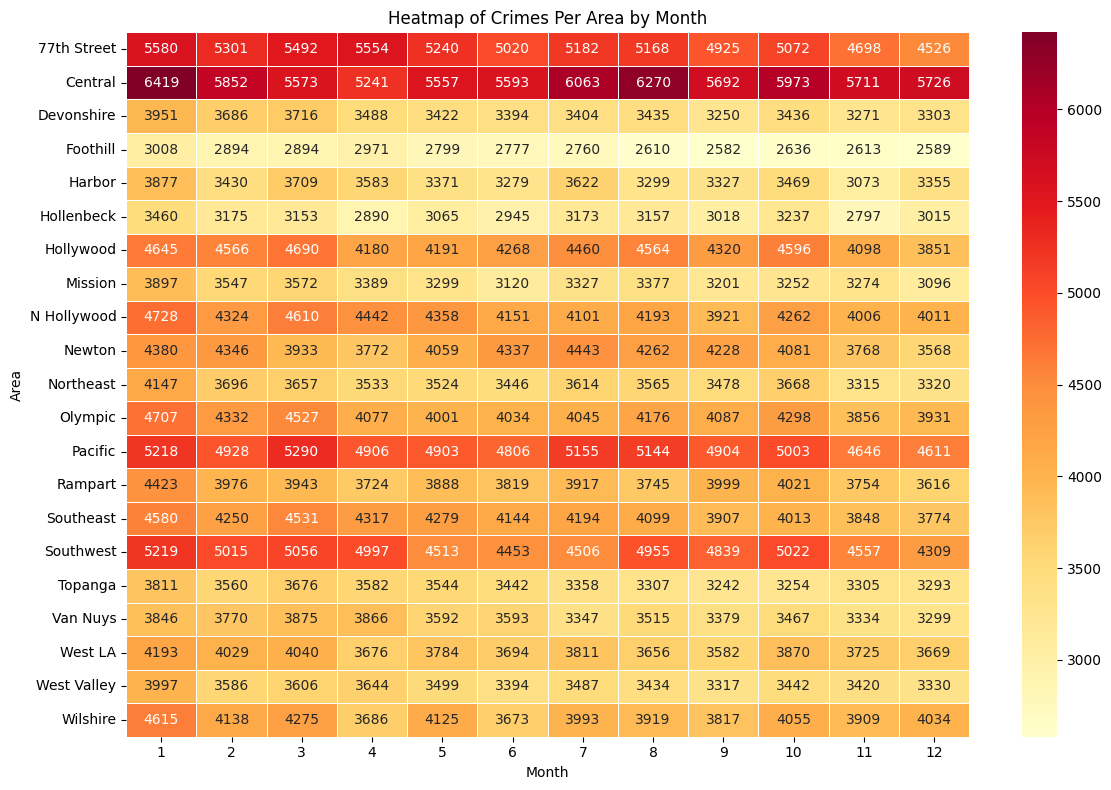

In [11]:
#10.Heatmap of crimes per area by month

query = """SELECT 
    AREA_NAME, MONTH(STR_TO_DATE(DATE_OCC, '%m/%d/%Y')) AS crime_month,
    COUNT(*) AS total_crimes FROM crime_data WHERE DATE_OCC IS NOT NULL GROUP BY AREA_NAME, crime_month ORDER BY crime_month, AREA_NAME;
"""
cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=['Area', 'Month', 'Total Crimes'])
pivot_table = df.pivot(index='Area', columns='Month', values='Total Crimes')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap of Crimes Per Area by Month")
plt.xlabel("Month")
plt.ylabel("Area")
plt.tight_layout()
plt.show()


C:\Users\BIT\AppData\Local\Temp\ipykernel_27392\1085903874.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_by_area, x='Area', y='Risk', palette='Reds_r')


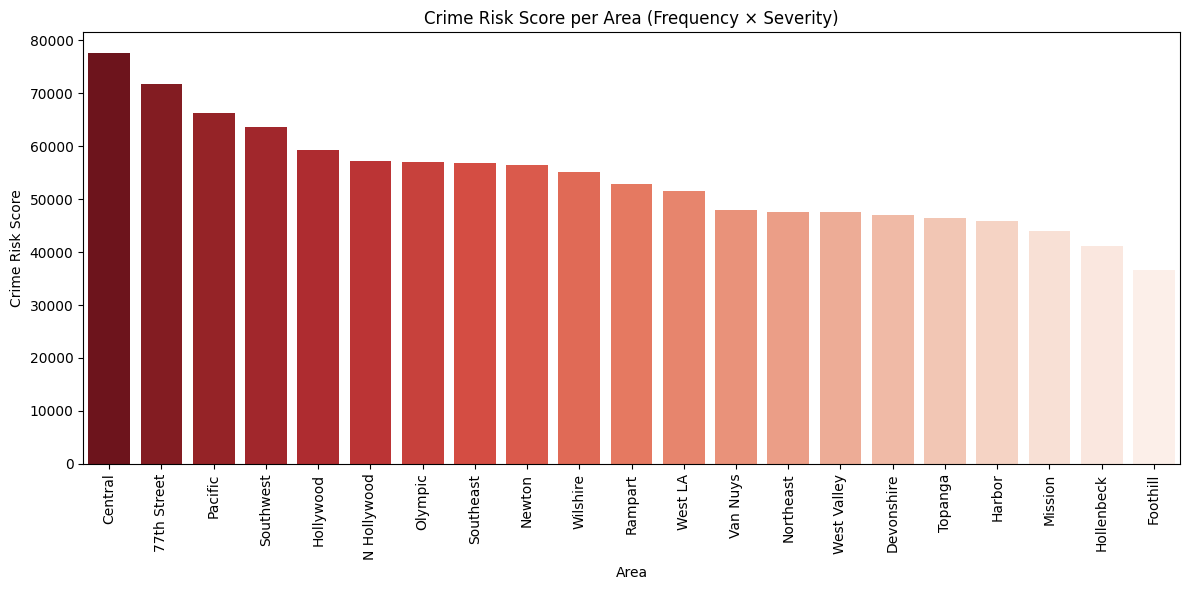

In [12]:
#11. Create a "Crime Risk Score" per area based on frequency & severity
query ="""
SELECT AREA_NAME,Crm_Cd_Desc,COUNT(*) AS crime_count FROM crime_data WHERE AREA_NAME IS NOT NULL AND Crm_Cd_Desc IS NOT NULL
GROUP BY AREA_NAME, Crm_Cd_Desc;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Area', 'Crime_Type', 'Crime_Count'])
severity_weights = {
    'HOMICIDE': 3, 'RAPE': 3, 'ROBBERY': 3,
    'ASSAULT': 2, 'BURGLARY': 2, 'ARSON': 2,
    'PETTY THEFT': 1, 'THEFT': 1, 'VANDALISM': 1, 'DRUNKENNESS': 1
}


df['Severity'] = df['Crime_Type'].map(severity_weights).fillna(1)


df['Risk'] = df['Crime_Count'] * df['Severity']


risk_by_area = df.groupby('Area')['Risk'].sum().reset_index()
risk_by_area = risk_by_area.sort_values(by='Risk', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=risk_by_area, x='Area', y='Risk', palette='Reds_r')
plt.xticks(rotation=90)
plt.title('Crime Risk Score per Area (Frequency × Severity)')
plt.ylabel('Crime Risk Score')
plt.xlabel('Area')
plt.tight_layout()
plt.show()

C:\Users\BIT\AppData\Local\Temp\ipykernel_27392\1784945940.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Area', x='Crime Risk Score', palette='Reds_r')


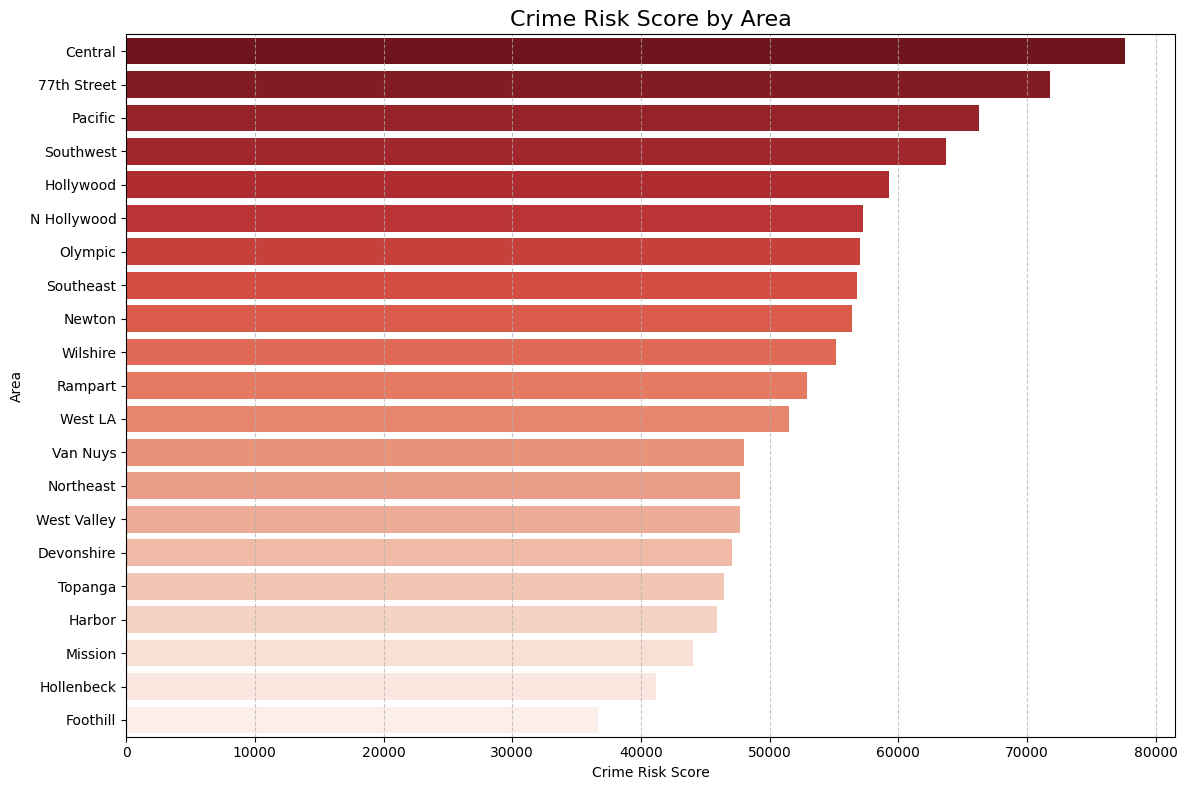

In [13]:
#12. Which descent group is most at risk per crime type?

query = """
SELECT AREA_NAME,
    SUM(
        CASE 
            WHEN Crm_Cd_Desc IN ('HOMICIDE', 'RAPE', 'ROBBERY') THEN 3
            WHEN Crm_Cd_Desc IN ('ASSAULT', 'BURGLARY', 'ARSON') THEN 2
            WHEN Crm_Cd_Desc IN ('PETTY THEFT', 'THEFT', 'VANDALISM', 'DRUNKENNESS') THEN 1
            ELSE 1
        END * crime_count
    ) AS crime_risk_score
FROM (
    SELECT  AREA_NAME, Crm_Cd_Desc, COUNT(*) AS crime_count
    FROM crime_data
    WHERE AREA_NAME IS NOT NULL AND Crm_Cd_Desc IS NOT NULL
    GROUP BY AREA_NAME, Crm_Cd_Desc
) AS crime_freq
GROUP BY AREA_NAME
ORDER BY crime_risk_score DESC;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Area', 'Crime Risk Score'])
plt.figure(figsize=(12, 8))
sns.barplot(data=df, y='Area', x='Crime Risk Score', palette='Reds_r')
plt.title('Crime Risk Score by Area', fontsize=16)
plt.xlabel('Crime Risk Score')
plt.ylabel('Area')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


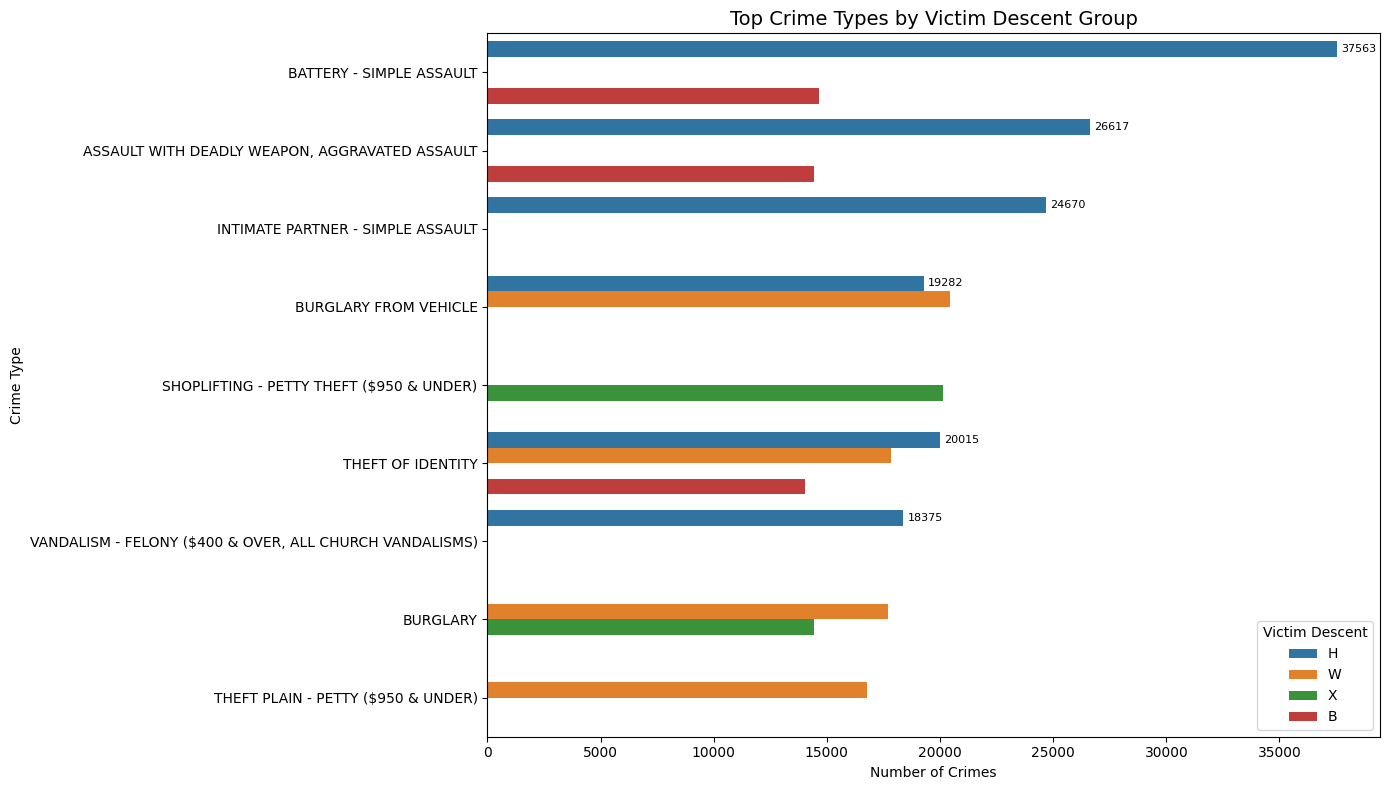

In [14]:
#12.Which descent group is most at risk per crime type?
query =""" Select Vict_Descent, Crm_Cd_Desc, count(*) as total_crimes from crime_data where  Crm_Cd_Desc IS NOT NULL AND
    Vict_Descent IS NOT NULL GROUP BY Vict_Descent, Crm_Cd_Desc ORDER BY total_crimes DESC;"""
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data, columns=['Victim Descent', 'Crime Type', 'Count of times'])

top_df = df.sort_values('Count of times', ascending=False).head(15)
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=top_df, y='Crime Type', x='Count of times', hue='Victim Descent')
ax.bar_label(ax.containers[0], padding=3, fontsize=8)
plt.title("Top Crime Types by Victim Descent Group", fontsize=14)
plt.xlabel("Number of Crimes")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()


C:\Users\BIT\AppData\Local\Temp\ipykernel_27392\1503333381.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


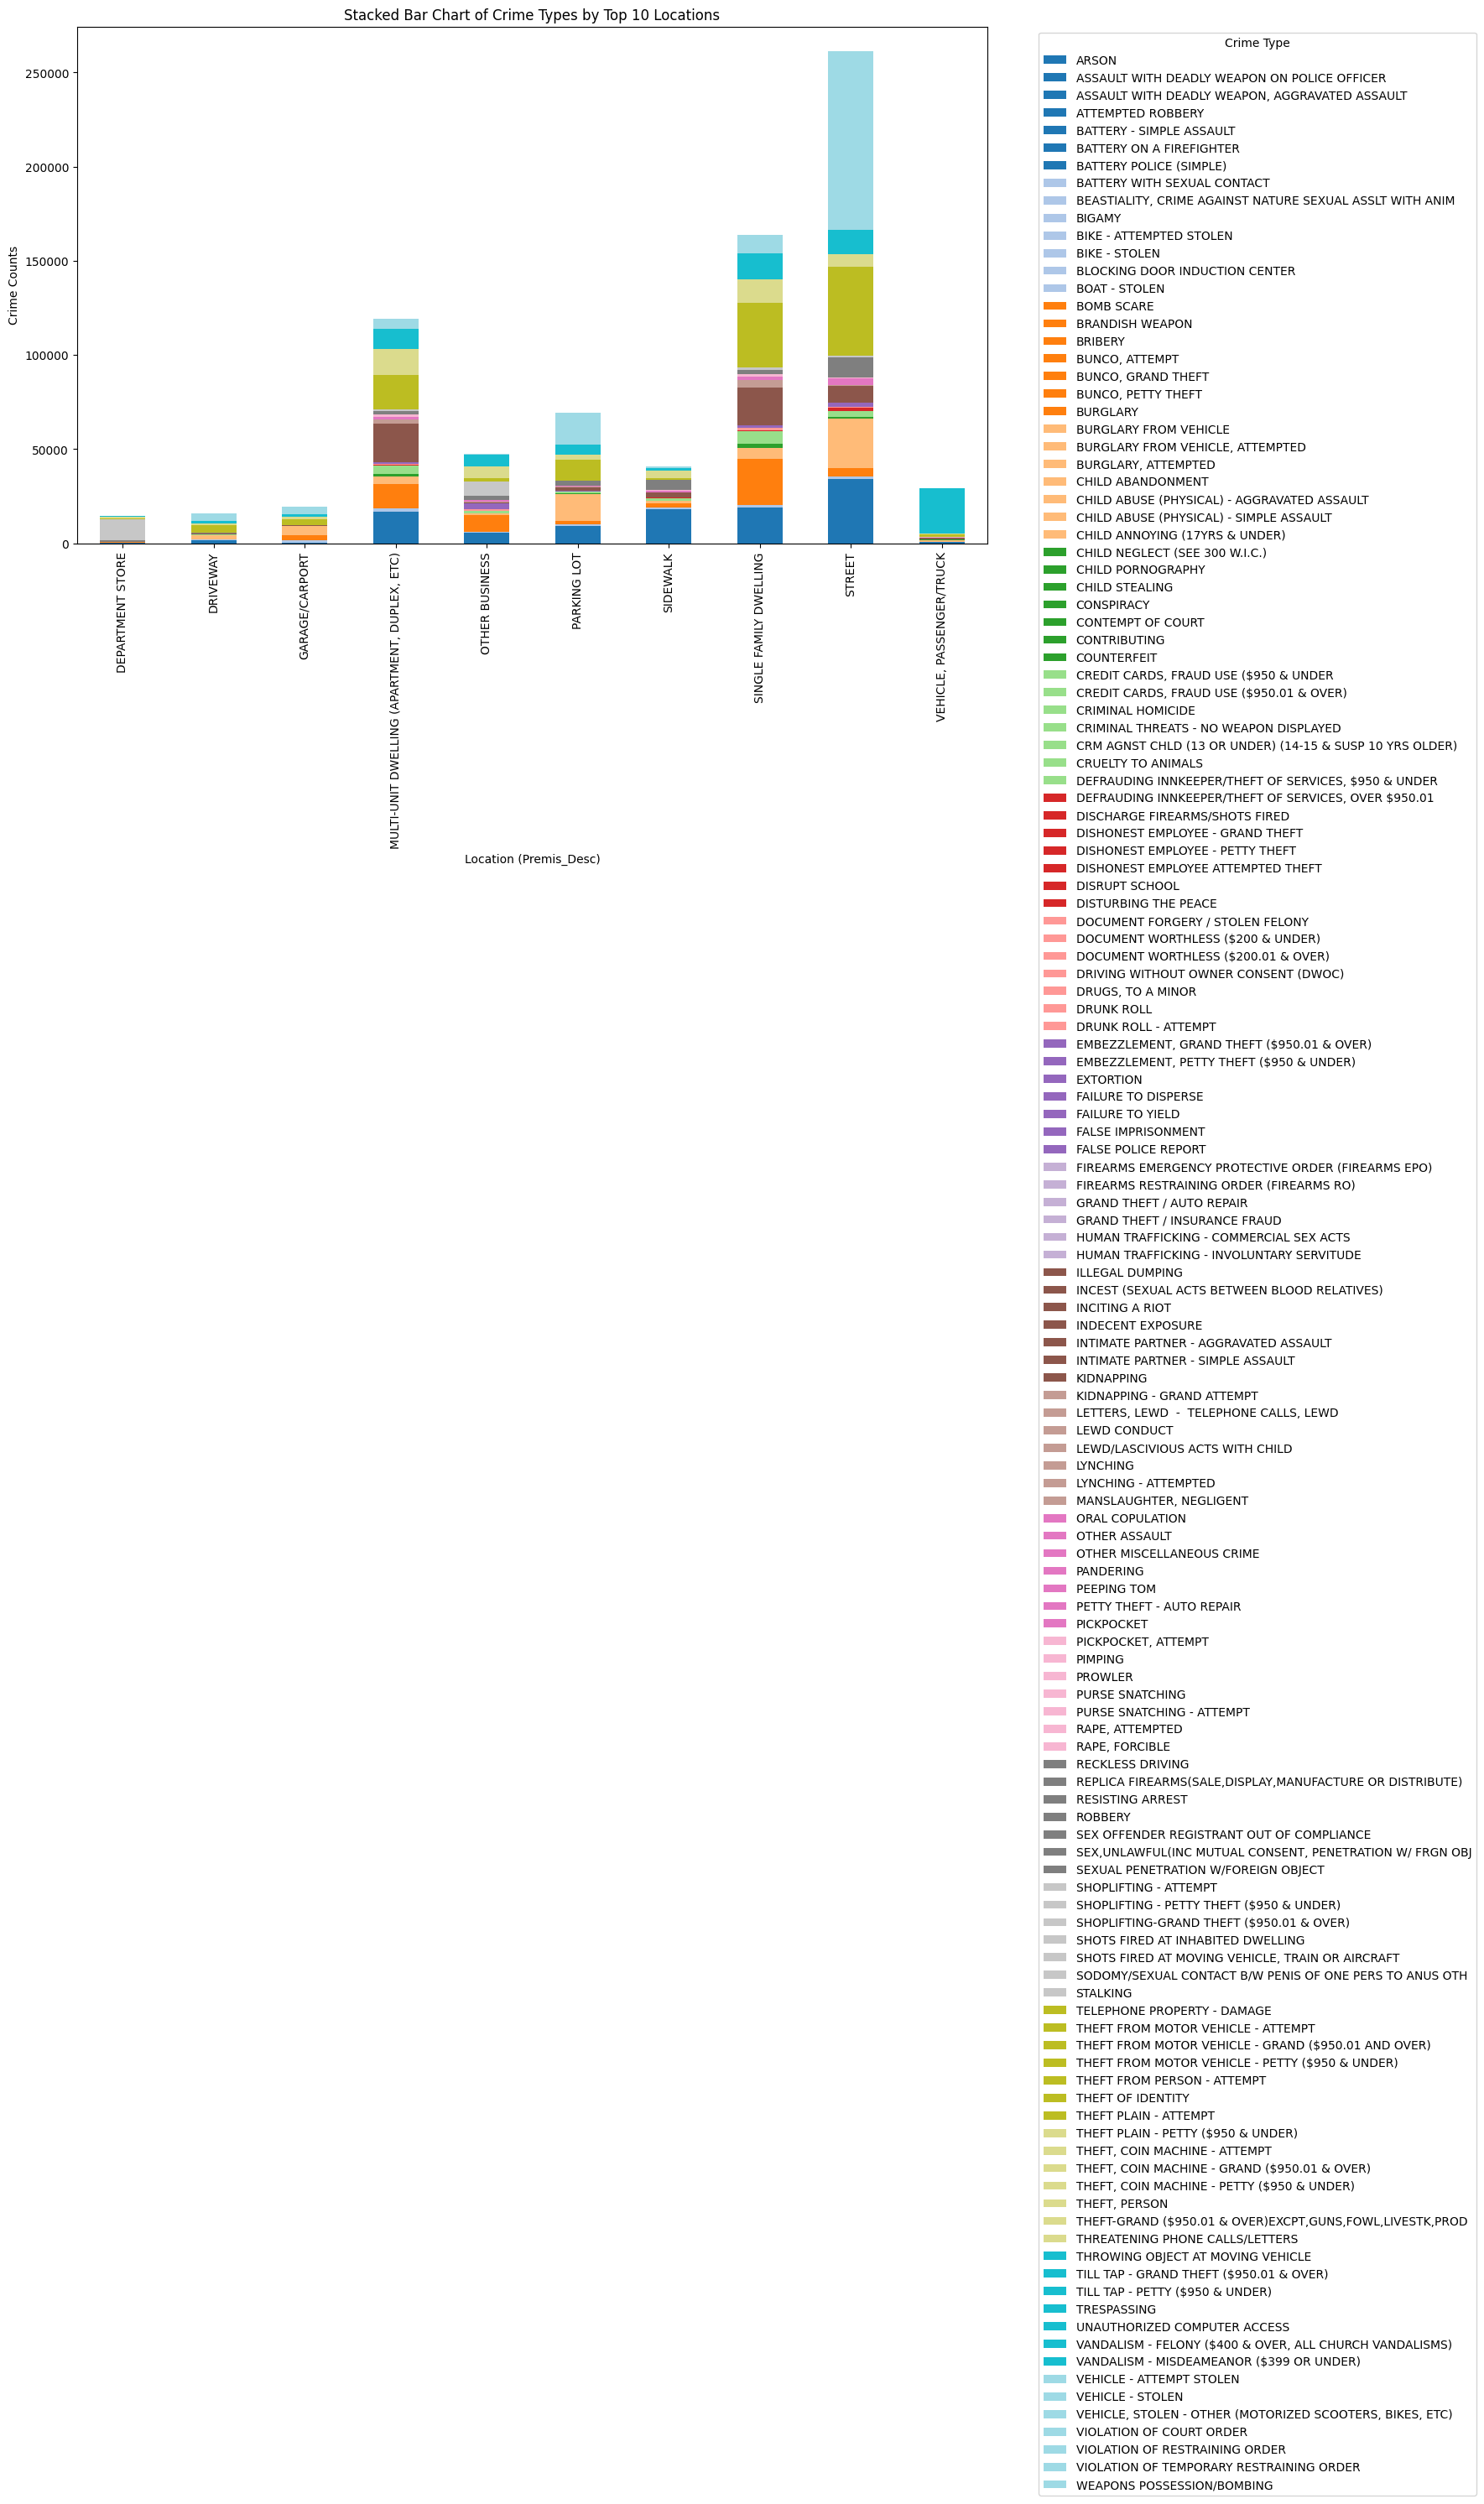

In [20]:
#13. Are certain locations (Premis Desc) more prone to specific crimes?
query ="""Select Premis_Desc, Crm_Cd_Desc, count(*) as counts 
from crime_data 
where Crm_Cd_Desc is not null and Premis_Desc is not null 
group by Premis_Desc, Crm_Cd_Desc 
order by Premis_Desc, counts desc """
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data, columns=["Premis_Desc", "Crm_Cd_Desc", "counts"])
heatmap_data = df.pivot_table(index="Premis_Desc", columns="Crm_Cd_Desc", values="counts", fill_value=0)

top_locations = df.groupby("Premis_Desc")["counts"].sum().nlargest(10).index

# Filter and pivot
df_top = df[df["Premis_Desc"].isin(top_locations)]
stacked_data = df_top.pivot_table(index="Premis_Desc", columns="Crm_Cd_Desc", values="counts", fill_value=0)

# Plot stacked bar chart
stacked_data.plot(kind="bar", stacked=True, figsize=(14, 8), colormap="tab20")
plt.title("Stacked Bar Chart of Crime Types by Top 10 Locations")
plt.xlabel("Location (Premis_Desc)")
plt.ylabel("Crime Counts")
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()